TODO 

- Check if all the clustering full dataset works
- Add z-score scaling and compute Kmeans, TSNE and Cosine with that data
- Make the same analysis using only the first k principal components
- (OPTIONAL) Make the same analysis using BERT embedding instead

In [ ]:
# TODO verificare correttezza min max scaling

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

# Description analysis

In [99]:
model = BertModel.from_pretrained('bert-base-cased')

In [100]:
max_length = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

alien_text = "In Alien, players take on the role of a lone astronaut stranded aboard a space station infested with deadly aliens. \
        The objective is to survive wave after wave of relentless alien attacks while attempting to escape the doomed station. \
        The game features a top-down perspective, with the player navigating through maze-like corridors filled with lurking aliens. \
        Armed with a limited supply of ammunition, players must strategically defend themselves against the alien onslaught. \
        The tension mounts as the aliens grow increasingly aggressive and numerous with each passing level."

iceHockey_text = "In Ice Hockey, players take control of a team of ice hockey players in a thrilling one-on-one matchup against the computer or another player. \
        The game features simple yet engaging gameplay mechanics, with players maneuvering their skaters across the icy rink to outmaneuver the opposition and score goals. \
        Using the joystick controller, players can control the direction and speed of their skaters, as well as perform actions such as passing, shooting, and checking."

pong_text = "In Pong, two players control paddles on either side of the screen, with the goal of hitting a ball back and forth between them. \
        The paddles move vertically and are controlled by players using knobs or joysticks. \
        The objective is to score points by successfully hitting the ball past the opponent's paddle. \
        The game features simple graphics consisting of two-dimensional paddles and a square ball bouncing across the screen. \
        As the game progresses, the ball's speed increases, making it more challenging for players to react and hit the ball."

airRaid_text = "In Air Raid, players must fend off waves of enemy aircraft while strategically managing their ammunition and fuel supplies. \
                The game unfolds with the player's jet stationed at the bottom of the screen, with a city skyline serving as the backdrop. \
                Enemy aircraft, depicted as various geometric shapes, descend from the top of the screen in relentless waves, unleashing barrages of projectiles as they attempt to destroy the player's jet and the city below. \
                Players control the fighter jet using the joystick controller, maneuvering left and right to evade enemy fire while returning fire to eliminate incoming threats. \
                The game's challenging mechanics require players to balance offensive and defensive strategies, carefully conserving ammunition and fuel to survive each increasingly difficult wave of attacks."

spaceInvaders_text = "In Space Invaders, players control a movable laser cannon situated at the bottom of the screen, aiming to eliminate descending formations of pixelated alien invaders. \
                The invaders gradually advance towards the bottom of the screen, firing back at the player in a coordinated assault. \
                As the player successfully shoots down aliens, the game's pace intensifies, with the remaining invaders moving faster and adopting more aggressive attack patterns. \
                Players must strategically dodge incoming enemy fire while aiming carefully to eliminate as many aliens as possible."

In [101]:
texts = [alien_text, airRaid_text, iceHockey_text, pong_text, spaceInvaders_text]
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=256)

## BERT CLS cosine similarity

In [102]:
# Extract BERT embeddings
with torch.no_grad():
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Use [CLS] token embeddings

In [103]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(embeddings)
print(similarity_matrix)

[[1.0000001  0.9639044  0.96845806 0.97544235 0.97979164]
 [0.9639044  1.0000002  0.98659813 0.9486867  0.97897553]
 [0.96845806 0.98659813 1.0000002  0.96792305 0.98553073]
 [0.97544235 0.9486867  0.96792305 1.         0.9785036 ]
 [0.97979164 0.97897553 0.98553073 0.9785036  1.        ]]


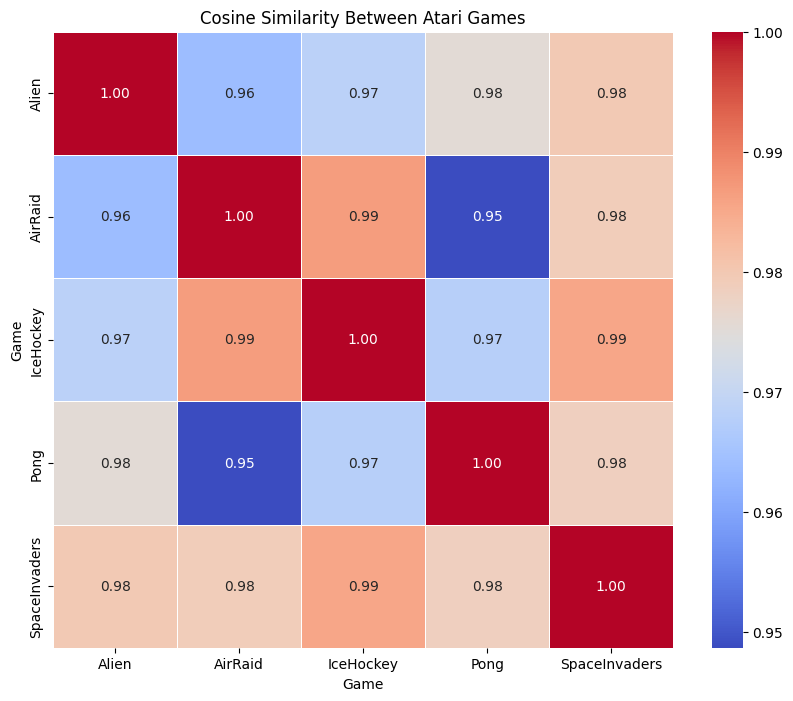

In [104]:
games = ["Alien", "AirRaid", "IceHockey", "Pong", "SpaceInvaders"]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, xticklabels=games, yticklabels=games)
plt.title('Cosine Similarity Between Atari Games')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()

## BERT embeddings cosine similarity

In [105]:
# Forward pass to obtain BERT embeddings
with torch.no_grad():
    outputs = model(**tokens)
    hidden_states = outputs.last_hidden_state

# Calculate the mean of the hidden states across all tokens for each text
mean_hidden_states = torch.mean(hidden_states, dim=1).numpy()

In [106]:
mean_hidden_states.shape

(5, 768)

In [107]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(mean_hidden_states)
similarity_matrix

array([[0.9999998 , 0.94461125, 0.922144  , 0.90996635, 0.9523222 ],
       [0.94461125, 0.9999998 , 0.90685296, 0.9258394 , 0.9533044 ],
       [0.922144  , 0.90685296, 0.9999998 , 0.943207  , 0.9258189 ],
       [0.90996635, 0.9258394 , 0.943207  , 1.0000001 , 0.9432001 ],
       [0.9523222 , 0.9533044 , 0.9258189 , 0.9432001 , 1.0000001 ]],
      dtype=float32)

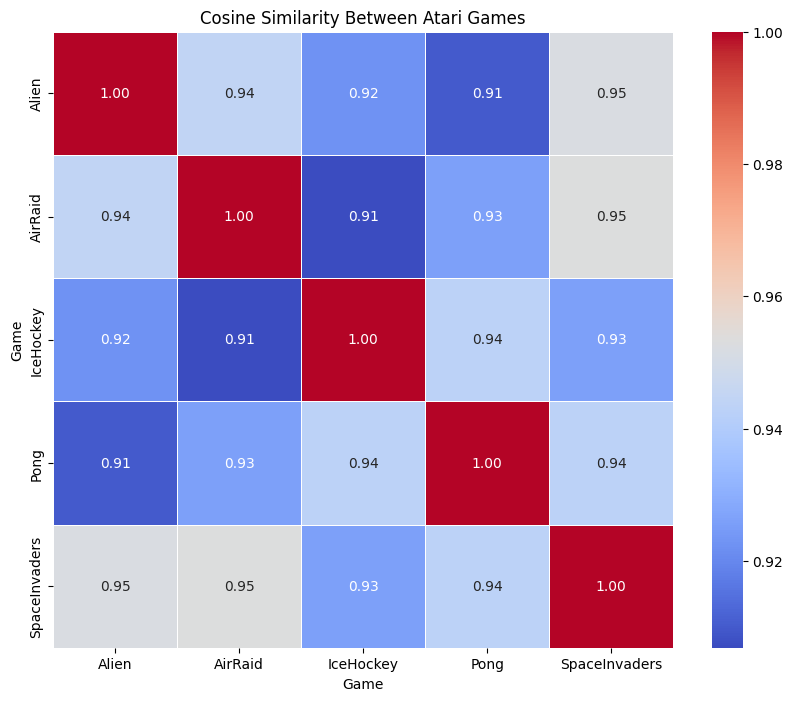

In [108]:
games = ["Alien", "AirRaid", "IceHockey", "Pong", "SpaceInvaders"]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, xticklabels=games, yticklabels=games)
plt.title('Cosine Similarity Between Atari Games')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()

# Load and concat data

In [2]:
text = "In Alien, players take on the role of a lone astronaut stranded aboard a space station infested with deadly aliens. \
            The objective is to survive wave after wave of relentless alien attacks while attempting to escape the doomed station. \
            The game features a top-down perspective, with the player navigating through maze-like corridors filled with lurking aliens. \
            Armed with a limited supply of ammunition, players must strategically defend themselves against the alien onslaught. \
            The tension mounts as the aliens grow increasingly aggressive and numerous with each passing level."

max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 624
Tokenized text length: 107
Bert ids length: 107


In [3]:
text = "In Ice Hockey, players take control of a team of ice hockey players in a thrilling one-on-one matchup against the computer or another player. \
            The game features simple yet engaging gameplay mechanics, with players maneuvering their skaters across the icy rink to outmaneuver the opposition and score goals. \
            Using the joystick controller, players can control the direction and speed of their skaters, as well as perform actions such as passing, shooting, and checking."

max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 490
Tokenized text length: 97
Bert ids length: 97


In [4]:
text = "In Pong, two players control paddles on either side of the screen, with the goal of hitting a ball back and forth between them. \
                The paddles move vertically and are controlled by players using knobs or joysticks. \
                The objective is to score points by successfully hitting the ball past the opponent's paddle. \
                The game features simple graphics consisting of two-dimensional paddles and a square ball bouncing across the screen. \
                As the game progresses, the ball's speed increases, making it more challenging for players to react and hit the ball."

max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 605
Tokenized text length: 113
Bert ids length: 113


In [5]:
text = "In Air Raid, players must fend off waves of enemy aircraft while strategically managing their ammunition and fuel supplies. \
                The game unfolds with the player's jet stationed at the bottom of the screen, with a city skyline serving as the backdrop. \
                Enemy aircraft, depicted as various geometric shapes, descend from the top of the screen in relentless waves, unleashing barrages of projectiles as they attempt to destroy the player's jet and the city below. \
                Players control the fighter jet using the joystick controller, maneuvering left and right to evade enemy fire while returning fire to eliminate incoming threats. \
                The game's challenging mechanics require players to balance offensive and defensive strategies, carefully conserving ammunition and fuel to survive each increasingly difficult wave of attacks."
max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 874
Tokenized text length: 157
Bert ids length: 157


In [6]:
text = "In Space Invaders, players control a movable laser cannon situated at the bottom of the screen, aiming to eliminate descending formations of pixelated alien invaders. \
        The invaders gradually advance towards the bottom of the screen, firing back at the player in a coordinated assault. \
        As the player successfully shoots down aliens, the game's pace intensifies, with the remaining invaders moving faster and adopting more aggressive attack patterns. \
        Players must strategically dodge incoming enemy fire while aiming carefully to eliminate as many aliens as possible."
max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 588
Tokenized text length: 106
Bert ids length: 106


In [2]:
max_length = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

games = ["Alien", "IceHockey", "Pong", "AirRaid", "SpaceInvaders"]

data = None

for game in games:

    file_path = f"./similarity_dataset/{game}.pkl"

    game_data = pd.read_pickle(file_path)

    if game == "Alien":
        text = "In Alien, players take on the role of a lone astronaut stranded aboard a space station infested with deadly aliens. \
                The objective is to survive wave after wave of relentless alien attacks while attempting to escape the doomed station. \
                The game features a top-down perspective, with the player navigating through maze-like corridors filled with lurking aliens. \
                Armed with a limited supply of ammunition, players must strategically defend themselves against the alien onslaught. \
                The tension mounts as the aliens grow increasingly aggressive and numerous with each passing level."
    elif game == "IceHockey":
        text = "In Ice Hockey, players take control of a team of ice hockey players in a thrilling one-on-one matchup against the computer or another player. \
                The game features simple yet engaging gameplay mechanics, with players maneuvering their skaters across the icy rink to outmaneuver the opposition and score goals. \
                Using the joystick controller, players can control the direction and speed of their skaters, as well as perform actions such as passing, shooting, and checking."
    elif game == "Pong":
        text = "In Pong, two players control paddles on either side of the screen, with the goal of hitting a ball back and forth between them. \
                The paddles move vertically and are controlled by players using knobs or joysticks. \
                The objective is to score points by successfully hitting the ball past the opponent's paddle. \
                The game features simple graphics consisting of two-dimensional paddles and a square ball bouncing across the screen. \
                As the game progresses, the ball's speed increases, making it more challenging for players to react and hit the ball."
    elif game == "AirRaid":
        text = "In Air Raid, players must fend off waves of enemy aircraft while strategically managing their ammunition and fuel supplies. \
                The game unfolds with the player's jet stationed at the bottom of the screen, with a city skyline serving as the backdrop. \
                Enemy aircraft, depicted as various geometric shapes, descend from the top of the screen in relentless waves, unleashing barrages of projectiles as they attempt to destroy the player's jet and the city below. \
                Players control the fighter jet using the joystick controller, maneuvering left and right to evade enemy fire while returning fire to eliminate incoming threats. \
                The game's challenging mechanics require players to balance offensive and defensive strategies, carefully conserving ammunition and fuel to survive each increasingly difficult wave of attacks."
    elif game == "SpaceInvaders":
        text = "In Space Invaders, players control a movable laser cannon situated at the bottom of the screen, aiming to eliminate descending formations of pixelated alien invaders. \
                The invaders gradually advance towards the bottom of the screen, firing back at the player in a coordinated assault. \
                As the player successfully shoots down aliens, the game's pace intensifies, with the remaining invaders moving faster and adopting more aggressive attack patterns. \
                Players must strategically dodge incoming enemy fire while aiming carefully to eliminate as many aliens as possible."
    else:
        text = None

    tokens = tokenizer.encode(text, max_length=max_length, truncation=True, padding='max_length')
    tokens = tokenizer.convert_tokens_to_ids(tokens)

    game_data['Text'] = [tokens] * len(game_data)

    game_data['Game'] = [game] * len(game_data)

    if data is None:
        data = game_data
    else:
        data = pd.concat([data, game_data], ignore_index=True)

In [3]:
cut = 512

# Exclude all the rows with an Action or a Reward smaller than cut
data = data[data['Action'].apply(lambda x: len(x)) >= cut]
data = data[data['Reward'].apply(lambda x: len(x)) >= cut]

data['Action'] = data['Action'].apply(lambda x: x[len(x)-cut:])
data['Reward'] = data['Reward'].apply(lambda x: x[len(x)-cut:])

In [116]:
data.head()

,Observation,Action,Reward,Text,Game
1,"[0.0, 9.55108642578125, 0.0, 0.0, 19.656047821...","[12, 14, 7, 7, 7, 12, 12, 12, 7, 7, 7, 7, 7, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",Alien
2,"[0.0, 12.90430736541748, 0.0, 0.0, 18.73797416...","[13, 1, 3, 1, 1, 12, 11, 8, 11, 16, 16, 5, 5, ...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",Alien
3,"[0.0, 7.280902862548828, 0.0, 0.0, 15.22757148...","[2, 14, 14, 1, 1, 2, 2, 2, 5, 2, 5, 6, 6, 6, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",Alien
4,"[0.0, 4.946225643157959, 0.0, 0.0, 16.17389297...","[9, 2, 5, 5, 9, 9, 9, 17, 17, 9, 9, 9, 9, 8, 9...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",Alien
5,"[0.0, 10.856890678405762, 0.0, 0.0, 16.0343742...","[16, 16, 16, 8, 16, 16, 16, 17, 17, 1, 2, 1, 1...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",Alien


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138526 entries, 1 to 140663
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Observation  138526 non-null  object
 1   Action       138526 non-null  object
 2   Reward       138526 non-null  object
 3   Text         138526 non-null  object
 4   Game         138526 non-null  object
dtypes: object(5)
memory usage: 6.3+ MB


In [118]:
n_games = len(data['Game'].unique())
n_games

5

# Data analysis

In [119]:
data_tmp = data.copy(deep=True)

## Vectors length check

In [120]:
def check_len(dataframe, col, des_len):
    # Assuming data_tmp is your DataFrame and 'Action' is the column of vectors
    vectors = dataframe[col].tolist()

    # Iterate through the rest of the vectors and compare their lengths with the first one
    all_same_length = all(len(vector) == des_len for vector in vectors)

    if all_same_length:
        print("All vectors have the same length:", des_len)
    else:
        print("Not all vectors have the same length.")

In [121]:
check_len(data_tmp, 'Action', 512)

All vectors have the same length: 512


In [122]:
check_len(data_tmp, 'Reward', 512)

All vectors have the same length: 512


In [123]:
check_len(data_tmp, 'Text', 256)

All vectors have the same length: 256


## Min values analysis

In [124]:
def get_min_values_boxplot(dataframe, game, columns):

    dataframe_tmp = dataframe[dataframe['Game'] == game].copy(deep=True)

    for column in columns:
        min_values = np.min(dataframe_tmp[column].tolist(), axis=1)
        dataframe_tmp[f'{column}_min'] = min_values

    dataframe_tmp.boxplot(column=[f'{col}_min' for col in columns])
    plt.title(f'Boxplots of {game} Minimum Values')
    plt.ylabel('Min Value')
    plt.xlabel('Columns')
    plt.show()

    del dataframe_tmp

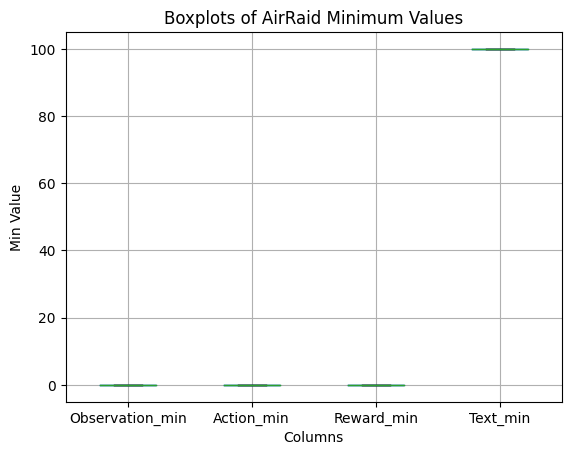

In [125]:
get_min_values_boxplot(data_tmp, 'AirRaid', ['Observation', 'Action', 'Reward', 'Text'])

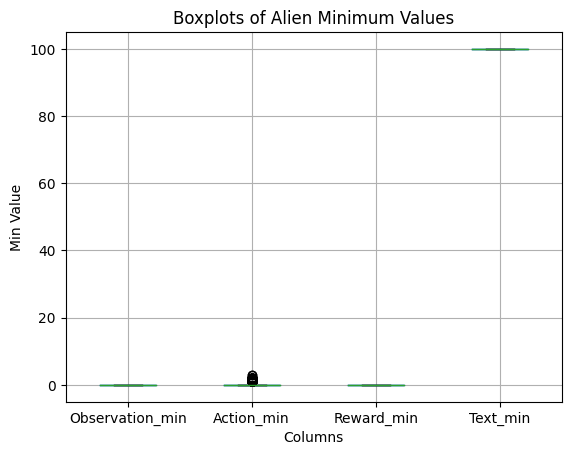

In [126]:
get_min_values_boxplot(data_tmp, 'Alien', ['Observation', 'Action', 'Reward', 'Text'])

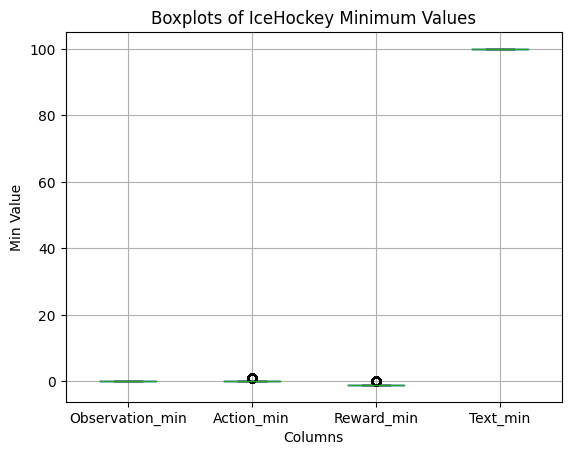

In [127]:
get_min_values_boxplot(data_tmp, 'IceHockey', ['Observation', 'Action', 'Reward', 'Text'])

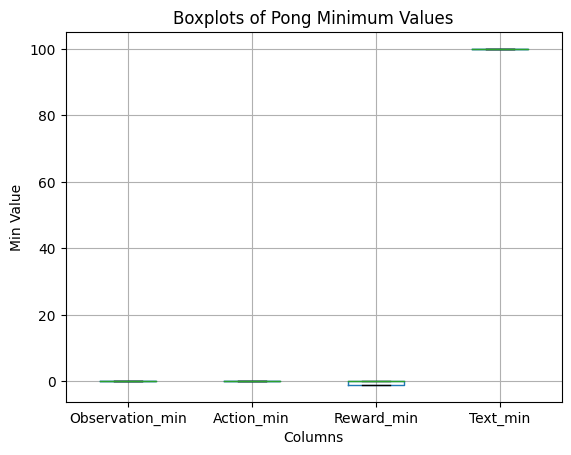

In [128]:
get_min_values_boxplot(data_tmp, 'Pong', ['Observation', 'Action', 'Reward', 'Text'])

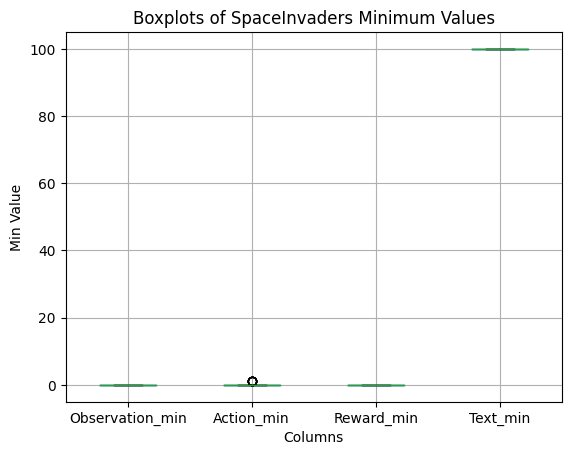

In [129]:
get_min_values_boxplot(data_tmp, 'SpaceInvaders', ['Observation', 'Action', 'Reward', 'Text'])

## Max values analysis

In [130]:
def get_max_values_boxplot(dataframe, game, columns):

    dataframe_tmp = dataframe[dataframe['Game'] == game].copy(deep=True)

    for column in columns:
        max_values = np.max(dataframe_tmp[column].tolist(), axis=1)
        dataframe_tmp[f'{column}_max'] = max_values

    dataframe_tmp.boxplot(column=[f'{col}_max' for col in columns])
    plt.title(f'Boxplots of {game} Maximum Values')
    plt.ylabel('Max Value')
    plt.xlabel('Columns')
    plt.show()

    del dataframe_tmp

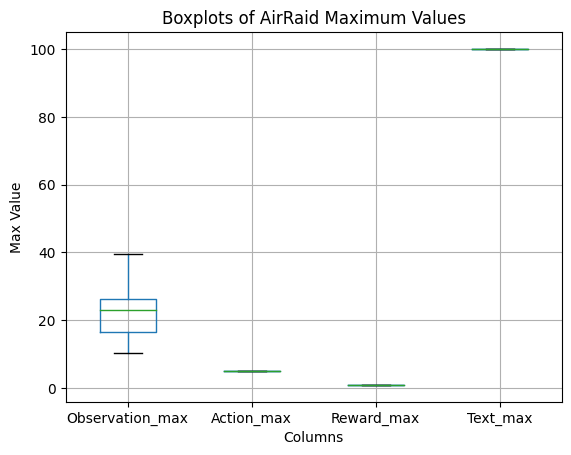

In [131]:
get_max_values_boxplot(data_tmp, 'AirRaid', ['Observation', 'Action', 'Reward', 'Text'])

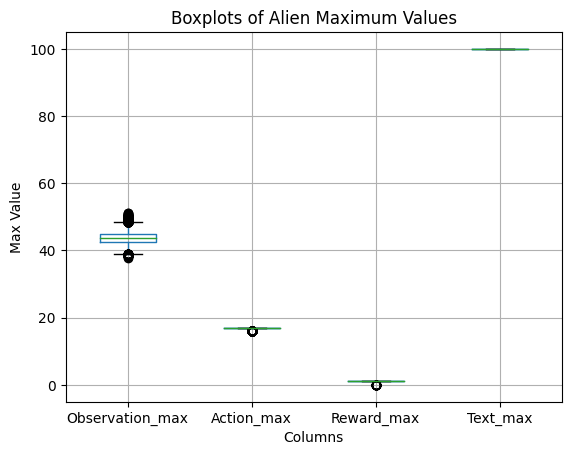

In [132]:
get_max_values_boxplot(data_tmp, 'Alien', ['Observation', 'Action', 'Reward', 'Text'])

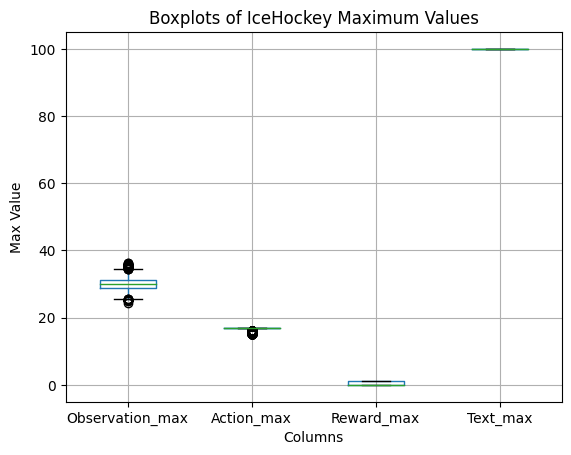

In [133]:
get_max_values_boxplot(data_tmp, 'IceHockey', ['Observation', 'Action', 'Reward', 'Text'])

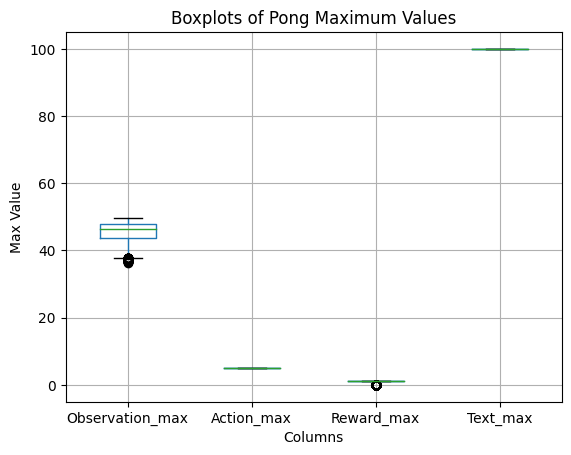

In [134]:
get_max_values_boxplot(data_tmp, 'Pong', ['Observation', 'Action', 'Reward', 'Text'])

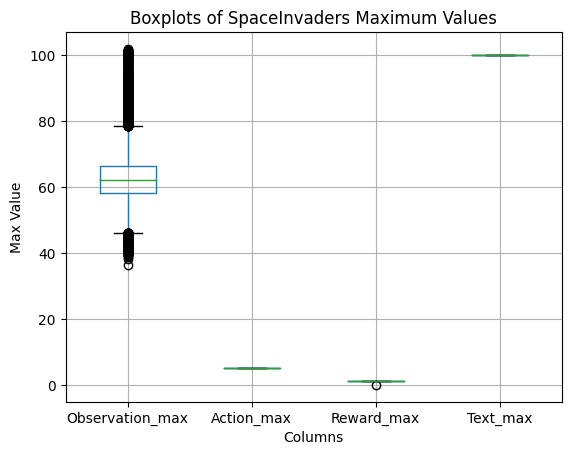

In [135]:
get_max_values_boxplot(data_tmp, 'SpaceInvaders', ['Observation', 'Action', 'Reward', 'Text'])

# Clustering only embedding

## K-means

In [12]:
# Convert 'Feature' column into a 2D numpy array
X = np.vstack(data['Observation'])

# Fit KMeans clustering
num_clusters = n_games
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.6639095744621986


In [13]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(X)

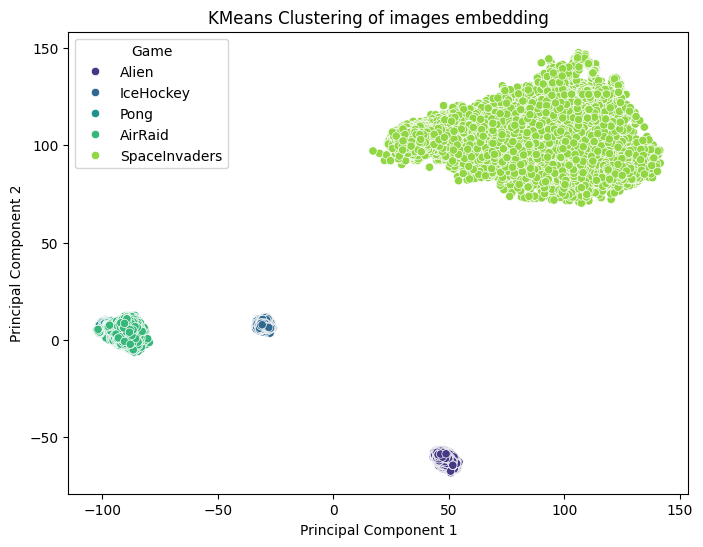

In [14]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=data['Game'], palette='viridis', legend='full')

plt.title('KMeans Clustering of images embedding')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Game')
plt.show()

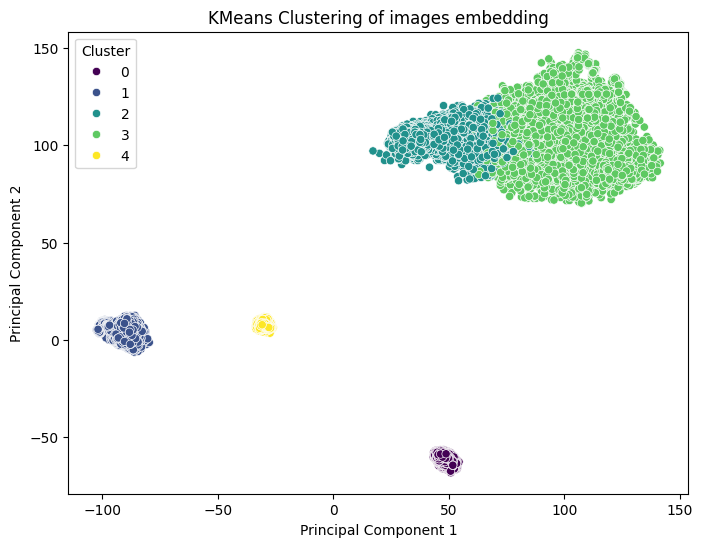

In [15]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=kmeans.labels_, palette='viridis', legend='full')

plt.title('KMeans Clustering of images embedding')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Best k search

In [26]:
def find_optimal_k(X, max_k=30):

    sse_list = list()

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(X)
        sse_list.append(kmeans.inertia_)

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

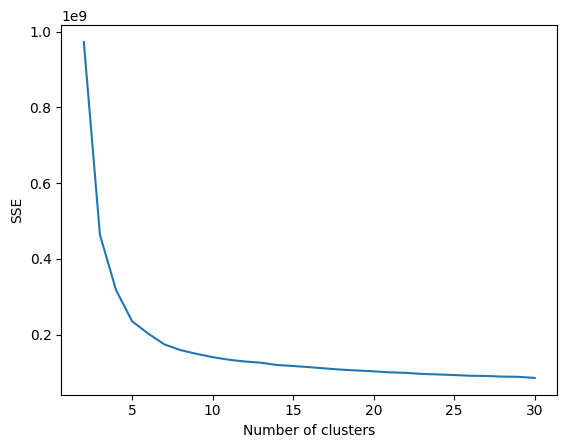

In [27]:
find_optimal_k(X)

Considering the above plot, the optimal k is equals to the number of games 

## TSNE

In [17]:
# Convert 'Feature' column into a 2D numpy array
X = np.vstack(data['Observation'])


tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_result = tsne.fit_transform(X)

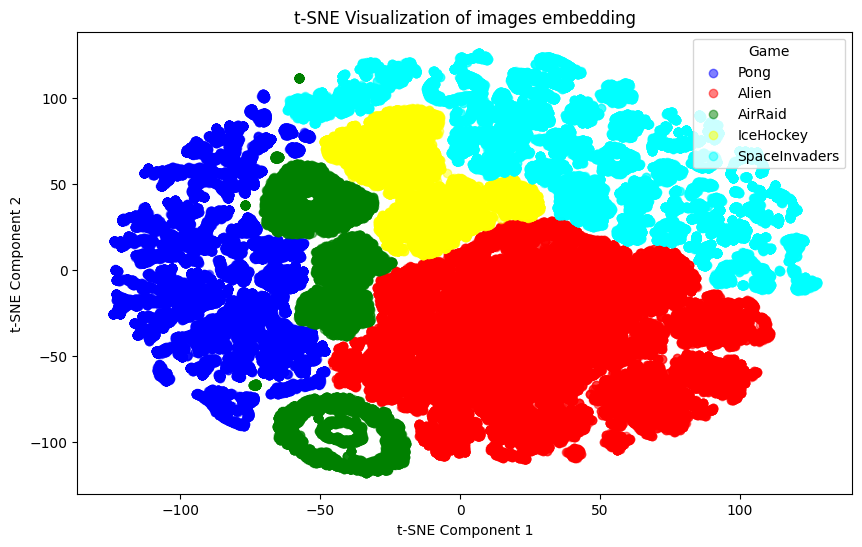

In [18]:
plt.figure(figsize=(10, 6))

# Define colors based on 'game' column
colors = {
    'Pong': 'blue',
    'Alien': 'red',
    'AirRaid': 'green',
    'IceHockey': 'yellow',
    'SpaceInvaders' : 'cyan'
}

# Iterate over unique games and plot each with a different color
for game, color in colors.items():
    indices = data['Game'] == game
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color=color, label=game, alpha=0.5)


plt.title('t-SNE Visualization of images embedding')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Game')
plt.show()

/tmp/ipykernel_1248659/2057122202.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


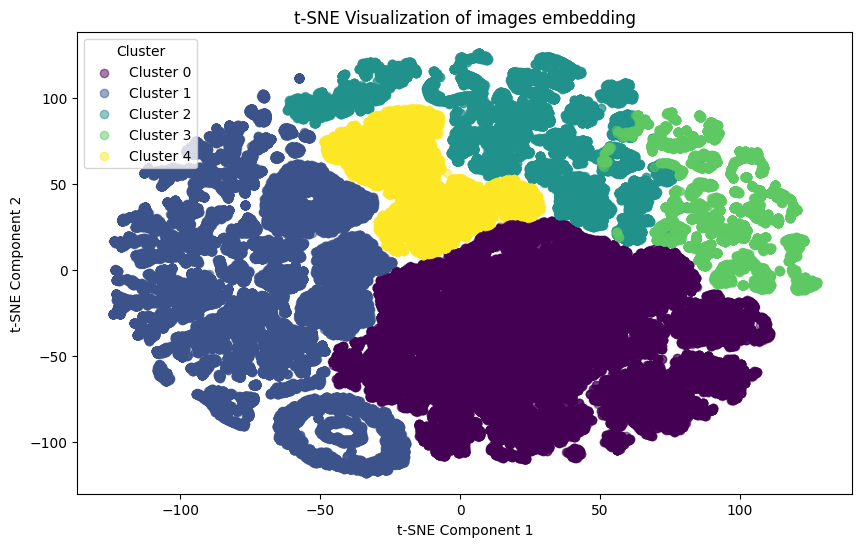

In [19]:
plt.figure(figsize=(10, 6))

# Get unique cluster labels
unique_labels = sorted(set(kmeans.labels_))

cmap = plt.cm.get_cmap('viridis', len(unique_labels))

# Plot data points with different colors based on KMeans labels
for label, color in zip(unique_labels, colors):
    indices = kmeans.labels_ == label
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color=cmap(label), label=f'Cluster {label}', alpha=0.5)


plt.title('t-SNE Visualization of images embedding')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

## Cosine similarity

In [10]:
games = data['Game'].unique()

In [11]:
game_similarity = pd.DataFrame(index=games, columns=games)

for i in range(len(games)):
    for j in range(len(games)):

        combined_vectors_game1 = np.stack(data[data['Game'] == games[i]]['Observation'].tolist())
        combined_vectors_game2 = np.stack(data[data['Game'] == games[j]]['Observation'].tolist())

        # Compute cosine similarity matrix
        cosine_sim_matrix = cosine_similarity(combined_vectors_game1, combined_vectors_game2)
        
        # Take the mean cosine similarity
        mean_cosine_similarity = np.mean(cosine_sim_matrix)

        game_similarity.loc[games[i], games[j]] = mean_cosine_similarity

In [12]:
game_similarity

,Alien,IceHockey,Pong,AirRaid,SpaceInvaders
Alien,0.984115,0.610807,0.235216,0.3524,0.544864
IceHockey,0.610807,0.987616,0.276632,0.370606,0.541304
Pong,0.235216,0.276632,0.894225,0.12708,0.241086
AirRaid,0.3524,0.370606,0.12708,0.425307,0.313222
SpaceInvaders,0.544864,0.541304,0.241086,0.313222,0.862168


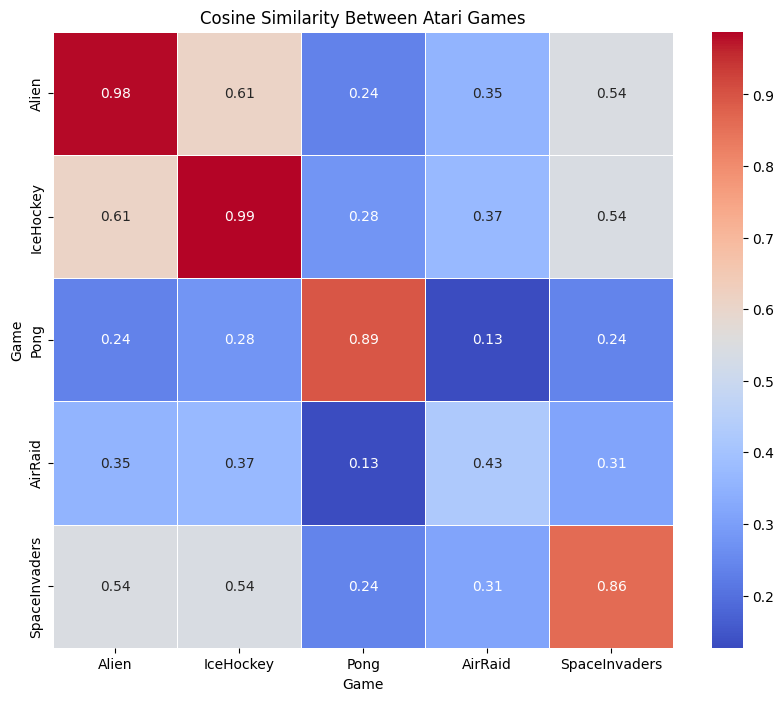

In [13]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(game_similarity.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Cosine Similarity Between Atari Games')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()

# Clustering dataset with embedding

## No scaling

In [136]:
# Create dataframe for kmeans
cut = 512
desired_length = 128 + 512 + 512 + 256

clustering_data = pd.DataFrame()
clustering_data['Observation'] = data['Observation']
clustering_data['Action'] = data['Action']
clustering_data['Reward'] = data['Reward']
clustering_data['Text'] = data['Text']
clustering_data['Game'] = data['Game']

# Function to concatenate elements of a list
def concatenate_elements(row):
    concatenated = []
    for column in clustering_data.columns:
        if column != 'Game':
            concatenated.extend(row[column])
    return concatenated

# Apply the function row-wise and create a new column
clustering_data['Feature'] = clustering_data.apply(concatenate_elements, axis=1)

# Convert lists in 'Feature' column to numpy arrays
clustering_data['Feature'] = clustering_data['Feature'].apply(lambda x: np.array(x))

### K-means

In [137]:
# Convert 'Feature' column into a 2D numpy array
X = np.vstack(clustering_data['Feature'])

# Fit KMeans clustering
num_clusters = n_games
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(np.stack(X))

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.36292533742583427


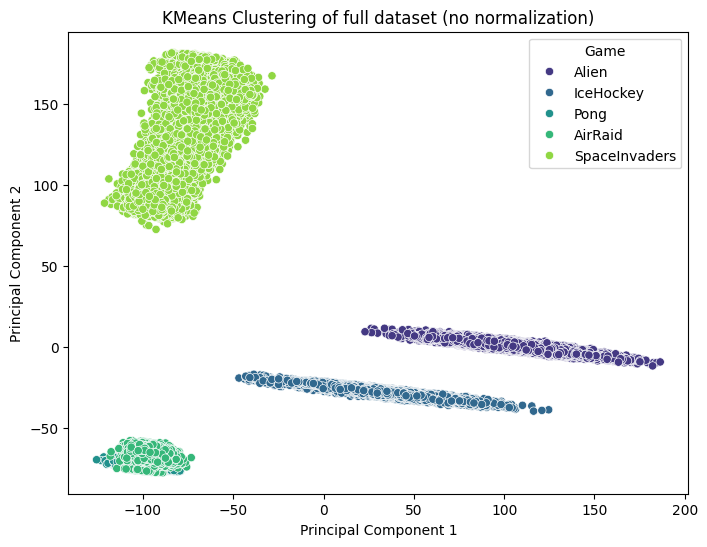

In [138]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=clustering_data['Game'], palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset (no normalization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Game')
plt.show()

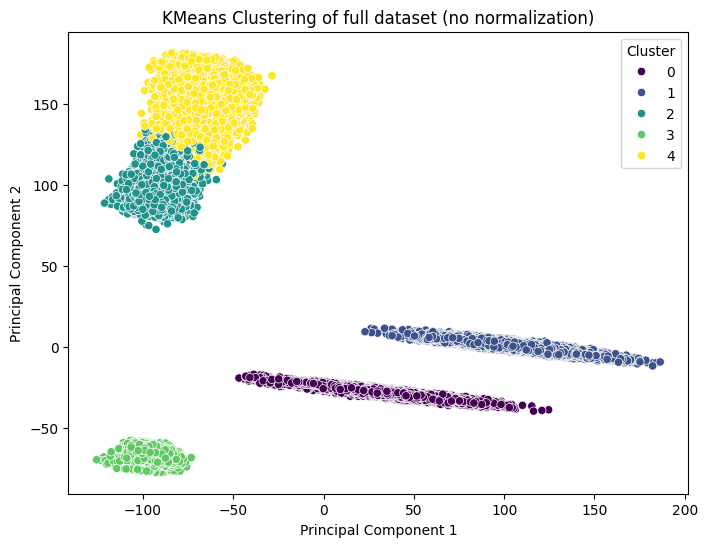

In [139]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=kmeans.labels_, palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset (no normalization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [73]:
def find_optimal_k(X, max_k=30):

    sse_list = list()

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(X)
        sse_list.append(kmeans.inertia_)

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.title('SSE curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

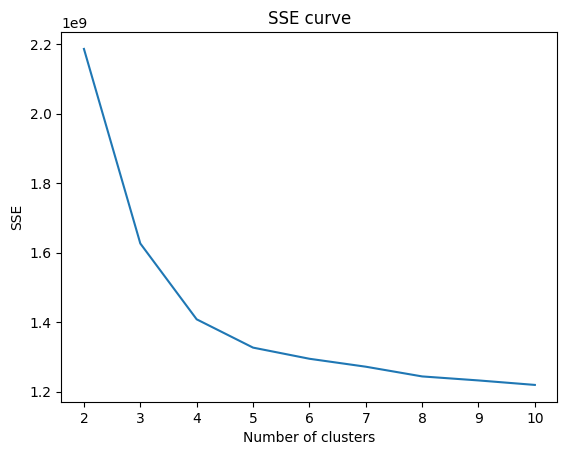

In [141]:
find_optimal_k(X, max_k=10)

The optimal k seems to be 4

In [142]:
# Convert 'Feature' column into a 2D numpy array
X = np.vstack(clustering_data['Feature'])

# Fit KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(np.stack(X))

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.37776493085871804


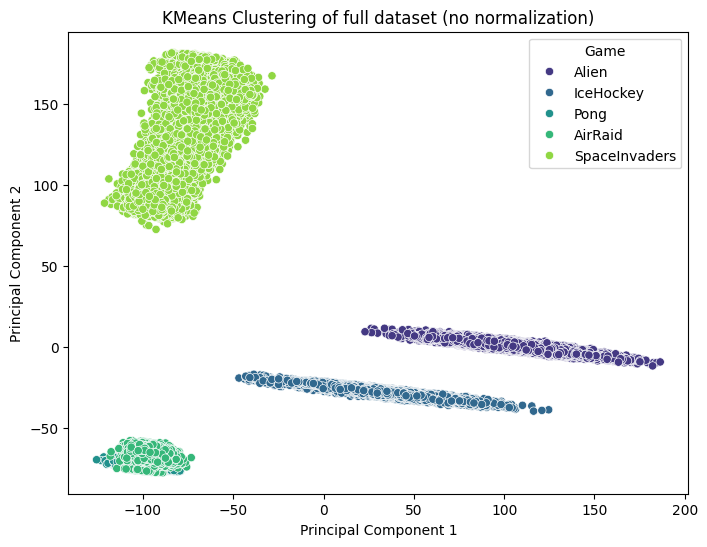

In [143]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=clustering_data['Game'], palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset (no normalization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Game')
plt.show()

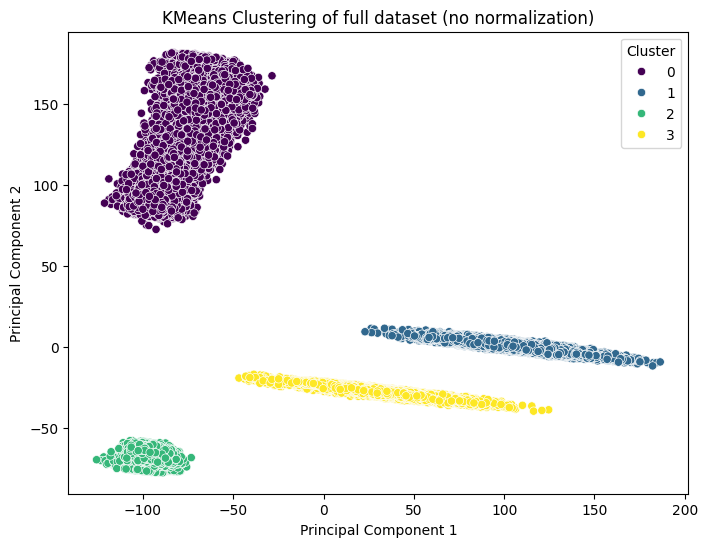

In [144]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=kmeans.labels_, palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset (no normalization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### TSNE

In [147]:
# Convert 'Feature' column into a 2D numpy array
X = np.vstack(clustering_data['Feature'])

# Initialize t-SNE model
tsne = TSNE(n_components=2, random_state=42) 

# Fit and transform the data
tsne_result = tsne.fit_transform(X)

<Figure size 1000x600 with 0 Axes>

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


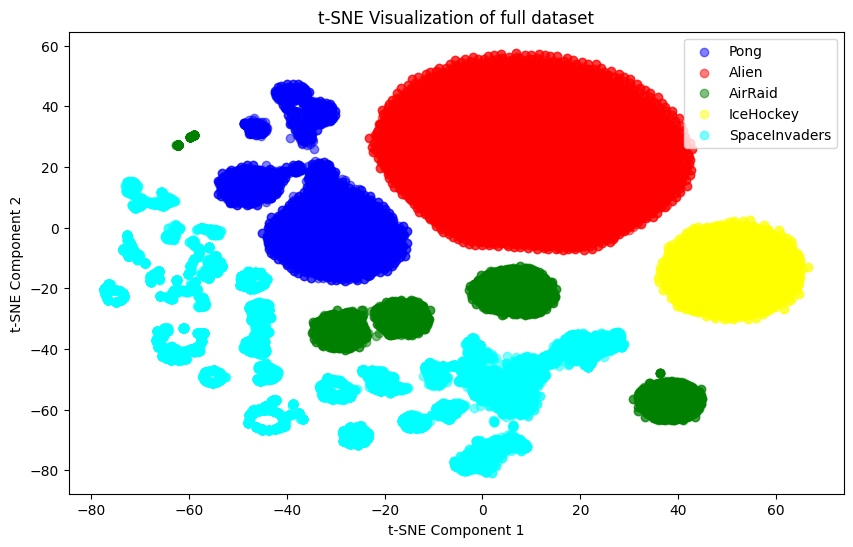

In [148]:
plt.figure(figsize=(10, 6))

# Define colors based on 'game' column
colors = {
    'Pong': 'blue',
    'Alien': 'red',
    'AirRaid': 'green',
    'IceHockey': 'yellow',
    'SpaceInvaders': 'cyan'
}

# Iterate over unique games and plot each with a different color
for game, color in colors.items():
    indices = clustering_data['Game'] == game
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color=color, label=game, alpha=0.5)

plt.title('t-SNE Visualization of full dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

/tmp/ipykernel_519304/2057122202.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


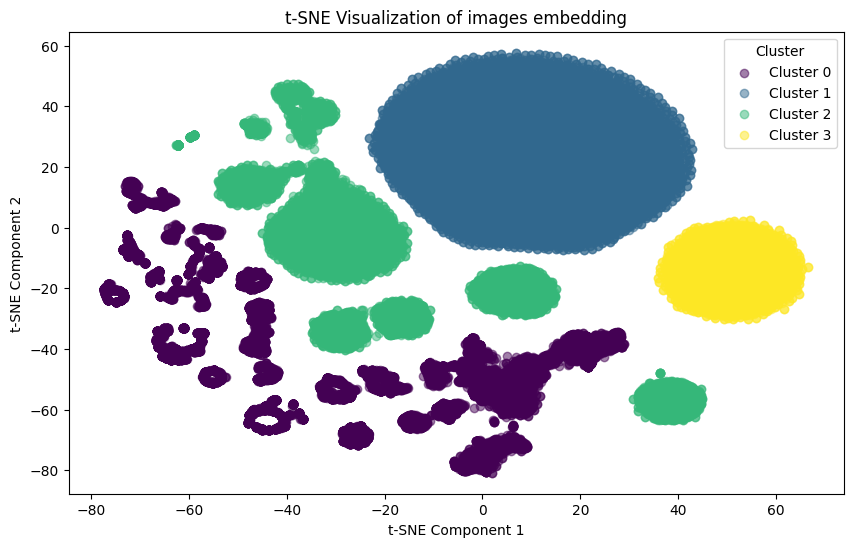

In [149]:
plt.figure(figsize=(10, 6))

# Get unique cluster labels
unique_labels = sorted(set(kmeans.labels_))

cmap = plt.cm.get_cmap('viridis', len(unique_labels))

# Plot data points with different colors based on KMeans labels
for label, color in zip(unique_labels, colors):
    indices = kmeans.labels_ == label
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color=cmap(label), label=f'Cluster {label}', alpha=0.5)


plt.title('t-SNE Visualization of images embedding')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

### Cosine similarity

In [150]:
similarity_data = pd.DataFrame()

similarity_data['Observation'] = clustering_data['Observation']
similarity_data['Action'] = clustering_data['Action']
similarity_data['Reward'] = clustering_data['Reward']
similarity_data['Text'] = clustering_data['Text']
similarity_data['Game'] = clustering_data['Game']

similarity_data['Combined'] = similarity_data.apply(lambda row: np.concatenate((row['Observation'], row['Action'], row['Reward'], row['Text']), axis=None), axis=1)

In [152]:
games = similarity_data['Game'].unique()

game_similarity = pd.DataFrame(index=games, columns=games)

for i in range(len(games)):
    for j in range(len(games)):

        combined_vectors_game1 = np.stack(similarity_data[similarity_data['Game'] == games[i]]['Combined'].tolist())
        combined_vectors_game2 = np.stack(similarity_data[similarity_data['Game'] == games[j]]['Combined'].tolist())

        # Compute cosine similarity matrix
        cosine_sim_matrix = cosine_similarity(combined_vectors_game1, combined_vectors_game2)
        
        # Take the mean cosine similarity
        mean_cosine_similarity = np.mean(cosine_sim_matrix)

        game_similarity.loc[games[i], games[j]] = mean_cosine_similarity

In [153]:
game_similarity

,Alien,IceHockey,Pong,AirRaid,SpaceInvaders
Alien,0.99453,0.990817,0.987652,0.98784,0.986114
IceHockey,0.990817,0.994054,0.990901,0.991021,0.987556
Pong,0.987652,0.990901,0.999299,0.998618,0.991108
AirRaid,0.98784,0.991021,0.998618,0.999044,0.991382
SpaceInvaders,0.986114,0.987556,0.991108,0.991382,0.9964


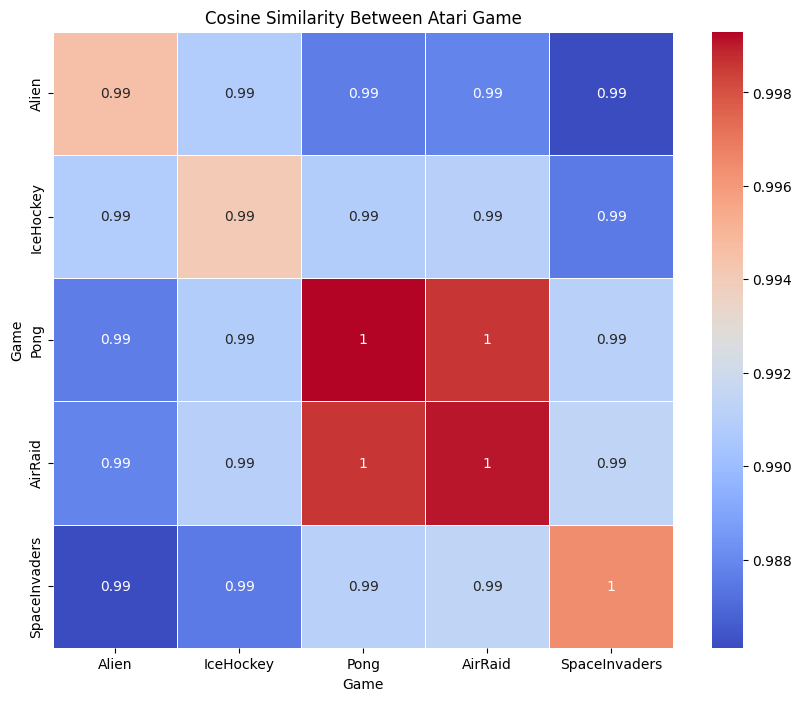

In [154]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(game_similarity.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Cosine Similarity Between Atari Game')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()

## Min-max scaling

### K-means

In [155]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(clustering_data['Feature'].to_list())

# Convert 'Feature' column into a 2D numpy array
X = np.vstack(normalized_data)

# Fit KMeans clustering
num_clusters = n_games
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(np.stack(X))

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.1256576895713471


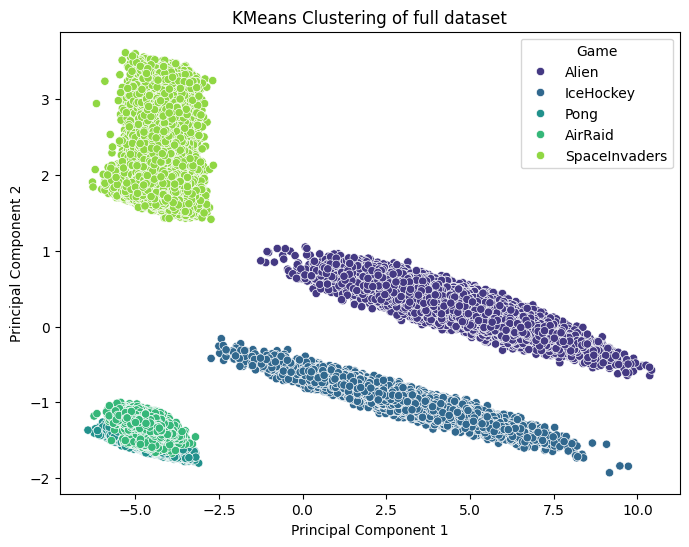

In [156]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=clustering_data['Game'], palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Game')
plt.show()

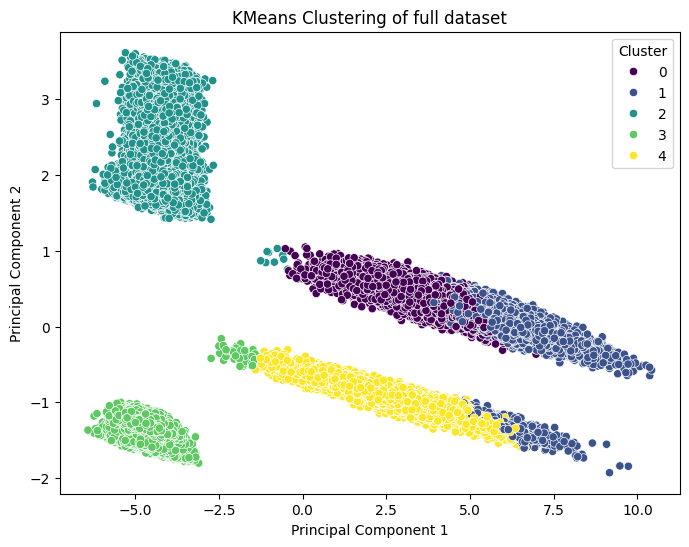

In [157]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=kmeans.labels_, palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

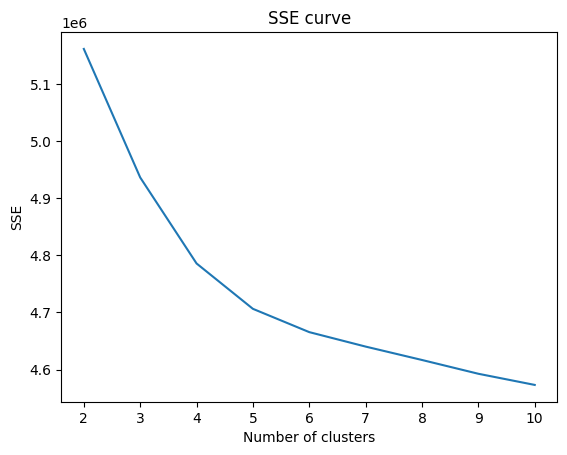

In [158]:
find_optimal_k(X, max_k=10)

In [159]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(clustering_data['Feature'].to_list())

# Convert 'Feature' column into a 2D numpy array
X = np.vstack(normalized_data)

# Fit KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(np.stack(X))

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.12883076222609352


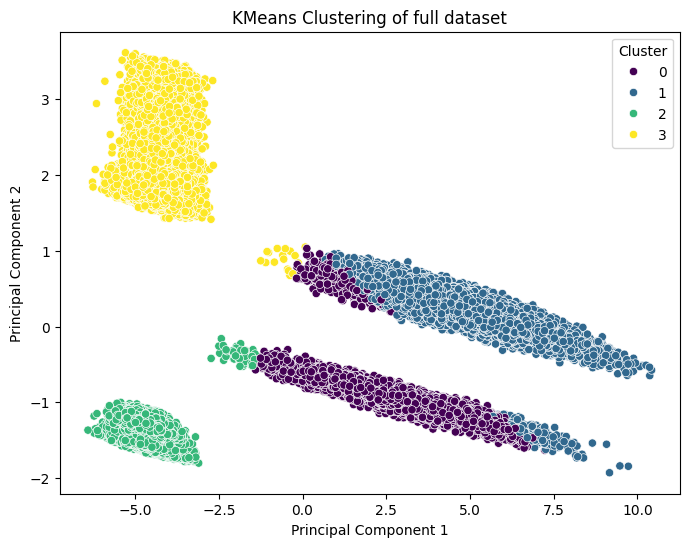

In [160]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=kmeans.labels_, palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### TSNE

In [161]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(clustering_data['Feature'].to_list())

In [162]:
# Convert 'Feature' column into a 2D numpy array
X = np.vstack(normalized_data)

tsne = TSNE(n_components=2, random_state=42) 

# Fit and transform the data
tsne_result = tsne.fit_transform(X)

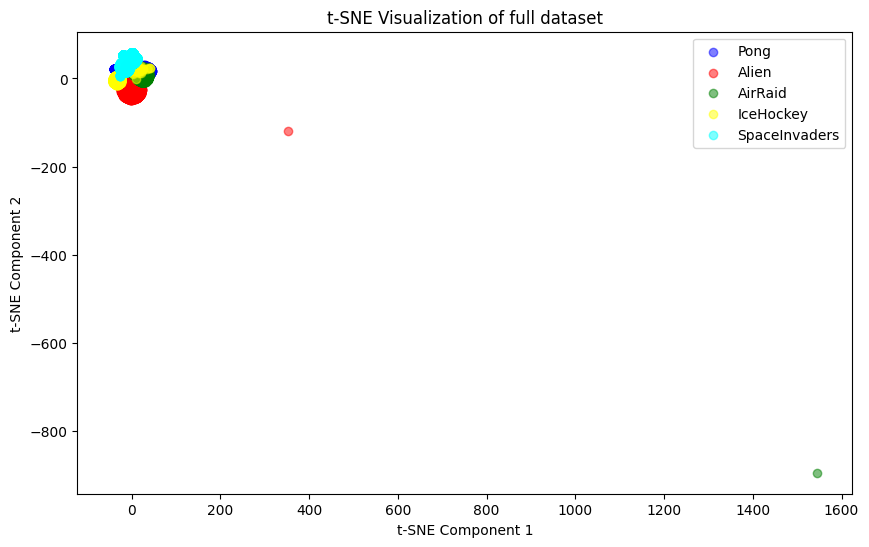

In [163]:
plt.figure(figsize=(10, 6))

# Define colors based on 'game' column
colors = {
    'Pong': 'blue',
    'Alien': 'red',
    'AirRaid': 'green',
    'IceHockey': 'yellow',
    'SpaceInvaders': 'cyan'
}

# Iterate over unique games and plot each with a different color
for game, color in colors.items():
    indices = clustering_data['Game'] == game
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color=color, label=game, alpha=0.5)

plt.title('t-SNE Visualization of full dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

/tmp/ipykernel_519304/2057122202.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


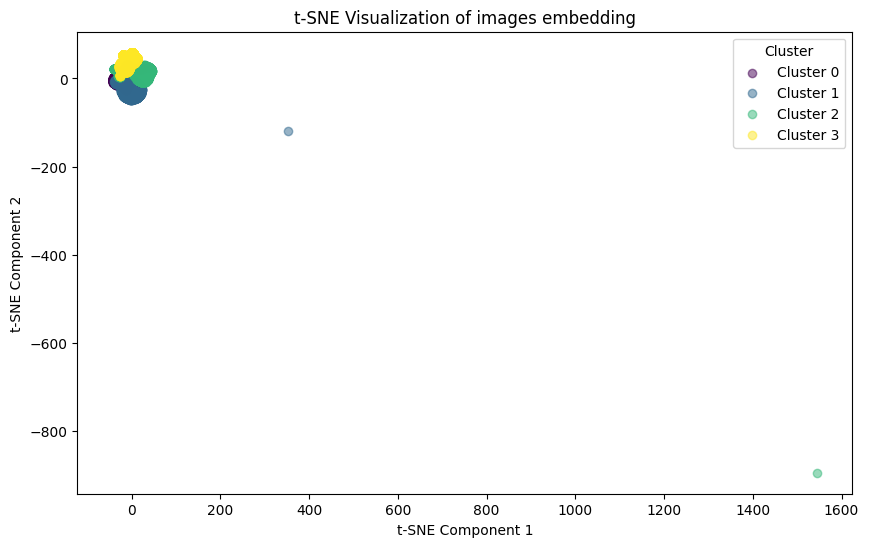

In [164]:
plt.figure(figsize=(10, 6))

# Get unique cluster labels
unique_labels = sorted(set(kmeans.labels_))

cmap = plt.cm.get_cmap('viridis', len(unique_labels))

# Plot data points with different colors based on KMeans labels
for label, color in zip(unique_labels, colors):
    indices = kmeans.labels_ == label
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color=cmap(label), label=f'Cluster {label}', alpha=0.5)


plt.title('t-SNE Visualization of images embedding')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

### Cosine similarity

In [165]:
# Normalize the data for all games
scaler = MinMaxScaler()
combined_vectors_normalized = scaler.fit_transform(similarity_data['Combined'].to_list())

# Compute the number of vectors per game
games = similarity_data.Game.unique()
num_vectors_per_game = list()

for game in games:
    num_vectors_per_game.append(len(similarity_data[similarity_data['Game'] == game]))


num_vectors_per_game

# Split the normalized vectors back into separate arrays for each game
start_index = 0
normalized_vectors_per_game = []
for num_vectors in num_vectors_per_game:
    end_index = start_index + num_vectors
    normalized_vectors_per_game.append(combined_vectors_normalized[start_index:end_index])
    start_index = end_index

# Compute cosine similarity between games
game_similarity = pd.DataFrame(index=games, columns=games)

for i in range(len(games)):
    for j in range(len(games)):
        combined_vectors_game1 = normalized_vectors_per_game[i]
        combined_vectors_game2 = normalized_vectors_per_game[j]
        
        # Compute cosine similarity matrix
        cosine_sim_matrix = cosine_similarity(combined_vectors_game1, combined_vectors_game2)
        
        # Take the mean cosine similarity
        mean_cosine_similarity = np.mean(cosine_sim_matrix)
        
        game_similarity.loc[games[i], games[j]] = mean_cosine_similarity

In [166]:
game_similarity

,Alien,IceHockey,Pong,AirRaid,SpaceInvaders
Alien,0.837149,0.813744,0.763938,0.749044,0.751244
IceHockey,0.813744,0.819072,0.768921,0.754269,0.747982
Pong,0.763938,0.768921,0.951984,0.932176,0.890352
AirRaid,0.749044,0.754269,0.932176,0.92818,0.882931
SpaceInvaders,0.751244,0.747982,0.890352,0.882931,0.920385


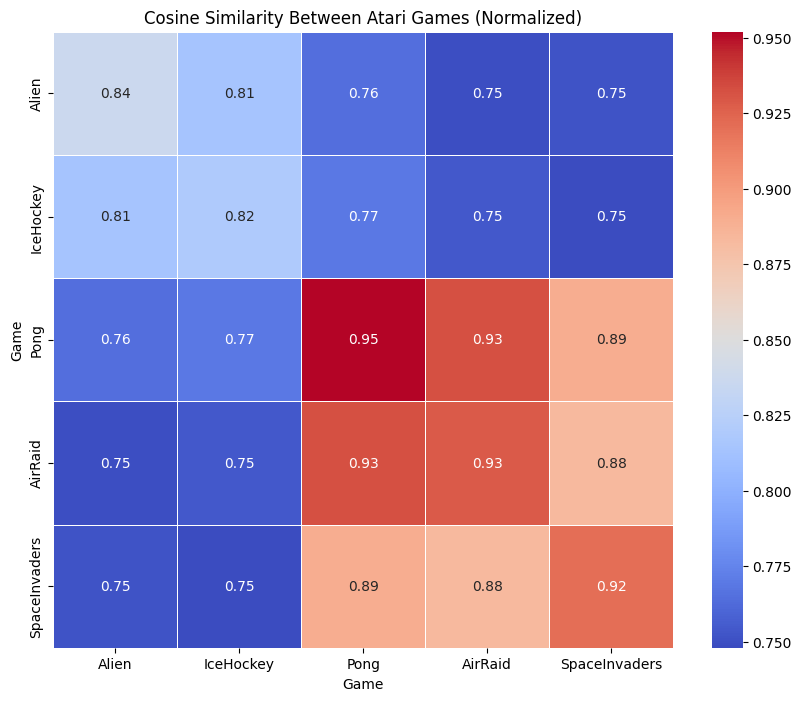

In [167]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(game_similarity.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Cosine Similarity Between Atari Games (Normalized)')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()

## Z-score scaling

### Preprocessing

In [ ]:
clustering_data_z = data.copy(deep=True)
clustering_data_z.info()

In [ ]:
# Function to concatenate elements of a list
def concatenate_elements(row):
    concatenated = []
    for column in clustering_data_z.columns:
        if column != 'Game':
            concatenated.extend(row[column])
    return concatenated

# Apply the function row-wise and create a new column
clustering_data_z['Feature'] = clustering_data_z.apply(concatenate_elements, axis=1)

# Convert lists in 'Feature' column to numpy arrays
clustering_data_z['Feature'] = clustering_data_z['Feature'].apply(lambda x: np.array(x))

In [ ]:
feature_column = np.array(clustering_data_z['Feature'].tolist())
feature_column.shape

In [ ]:
mean_features = np.mean(feature_column, axis=0)
std_features = np.std(feature_column, axis=0)

print(len(mean_features))
print(len(std_features))

In [ ]:
zero_indices = np.where(std_features == 0)[0]
len(zero_indices)

In [ ]:
zero_indices

There are some columns that have 0 as std so we drop them because are not significative for the analysis. 

N.B. 
Most of the indices with 0 std belong to the tokenized text

In [ ]:
# Drop elements from the vector at zero indices
filtered_mean = np.delete(mean_features, zero_indices)
filtered_std = np.delete(std_features, zero_indices)
# Drop columns with zero indices
filtered_features = np.delete(feature_column, zero_indices, axis=1)

In [ ]:
normalized_feature_column = np.array([(np.array(row) - filtered_mean) / filtered_std for row in filtered_features])
#clustering_data_z['Feature_norm'] = normalized_feature_column

In [ ]:
normalized_feature_column.shape

### K-means

In [71]:
n_games = len(clustering_data_z.Game.unique())
n_games

5

In [72]:
# Convert 'Feature' column into a 2D numpy array
X = normalized_feature_column

# Fit KMeans clustering
num_clusters = n_games
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(np.stack(X))

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.07861426240653853


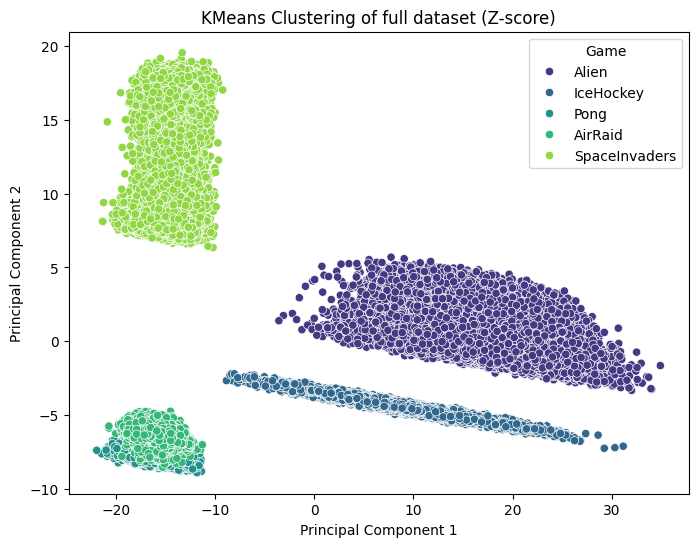

In [74]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=clustering_data_z['Game'], palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset (Z-score)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Game')
plt.show()

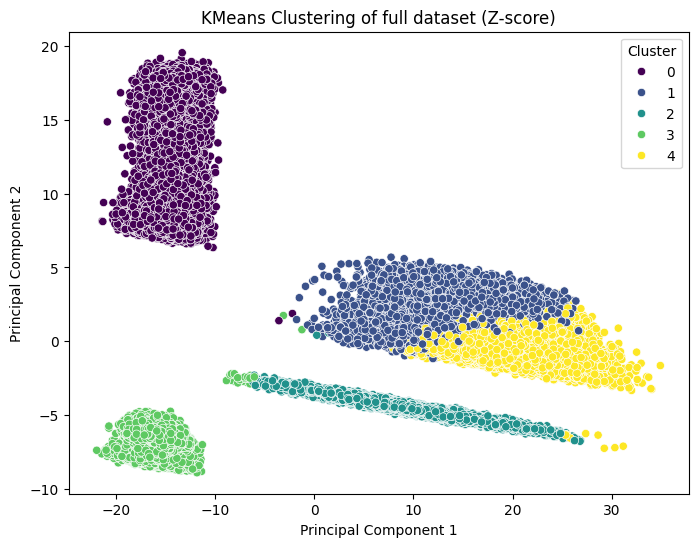

In [75]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=kmeans.labels_, palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset (Z-score)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

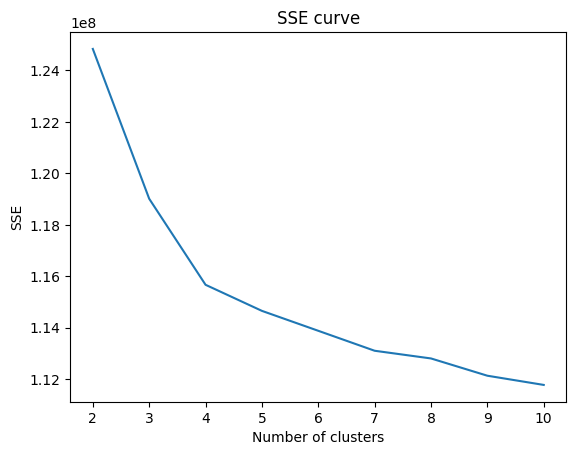

In [80]:
find_optimal_k(X, max_k=10)

The optimal number of clusters seems to be 4

In [81]:
# Fit KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(np.stack(X))

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=clustering_data_z['Game'], palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset (Z-score)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Game')
plt.show()

In [ ]:
# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_pca[:, 0], y=feature_pca[:, 1], hue=kmeans.labels_, palette='viridis', legend='full')

plt.title('KMeans Clustering of full dataset (Z-score)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### TSNE

In [ ]:
plt.figure(figsize=(10, 6))

# Define colors based on 'game' column
colors = {
    'Pong': 'blue',
    'Alien': 'red',
    'AirRaid': 'green',
    'IceHockey': 'yellow',
    'SpaceInvaders': 'cyan'
}

# Iterate over unique games and plot each with a different color
for game, color in colors.items():
    indices = clustering_data_z['Game'] == game
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color=color, label=game, alpha=0.5)

plt.title('t-SNE Visualization of full dataset (Z-score)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Get unique cluster labels
unique_labels = sorted(set(kmeans.labels_))

cmap = plt.cm.get_cmap('viridis', len(unique_labels))

# Plot data points with different colors based on KMeans labels
for label, color in zip(unique_labels, colors):
    indices = kmeans.labels_ == label
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color=cmap(label), label=f'Cluster {label}', alpha=0.5)


plt.title('t-SNE Visualization of images embedding (Z-score)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

### Cosine similarity

In [ ]:
similarity_data = pd.DataFrame()

similarity_data['Observation'] = clustering_data_z['Observation']
similarity_data['Action'] = clustering_data_z['Action']
similarity_data['Reward'] = clustering_data_z['Reward']
similarity_data['Text'] = clustering_data_z['Text']
similarity_data['Game'] = clustering_data_z['Game']

similarity_data['Combined'] = similarity_data.apply(lambda row: np.concatenate((row['Observation'], row['Action'], row['Reward'], row['Text']), axis=None), axis=1)

In [ ]:
games = similarity_data['Game'].unique()

game_similarity = pd.DataFrame(index=games, columns=games)

for i in range(len(games)):
    for j in range(len(games)):

        combined_vectors_game1 = np.stack(similarity_data[similarity_data['Game'] == games[i]]['Combined'].tolist())
        combined_vectors_game2 = np.stack(similarity_data[similarity_data['Game'] == games[j]]['Combined'].tolist())

        # Compute cosine similarity matrix
        cosine_sim_matrix = cosine_similarity(combined_vectors_game1, combined_vectors_game2)
        
        # Take the mean cosine similarity
        mean_cosine_similarity = np.mean(cosine_sim_matrix)

        game_similarity.loc[games[i], games[j]] = mean_cosine_similarity

In [ ]:
game_similarity

In [ ]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(game_similarity.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Cosine Similarity Between Atari Game')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()

# Similarity on the first k principal components